Multivariate SARIMAX forecasting practice 
Deux variables sont utilisees
Nuitees dans l'hôtellerie
AvgTemp 
Datasets used
    Nuitées dans l'hôtellerie - Total - Pays de la Loire https://www.insee.fr/fr/statistiques/serie/001711049
    Meteo France meteo2010-2015.csv, meteo2016-2017.csv https://drive.google.com/drive/folders/18qfXh5G4NxFWlz8PVcgIDOuJKaWieNpZ

In [47]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import pyramid
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

In [48]:
dn = pd.read_csv('datasets/valeurs_mensuelles.csv', sep=";", names=["Date","Nights"],index_col=[0], parse_dates=[0],usecols=[0, 1],skiprows=range(0, 3),header=None)
dn.head()

,Nights
Date,
2018-06-01,772.50
2018-05-01,691.32
2018-04-01,640.27
2018-03-01,519.03
2018-02-01,447.08


In [49]:
french_months =['janvier','février','mars','avril','mai','juin','juillet','aout','septembre','octobre','novembre','décembre']
dm1 = pd.read_csv('datasets/meteo_2010_2015.csv', sep=",", names=['Year', 'Month', 'Region', 'AvgTemp'], usecols=[1, 2, 3, 4],skiprows=range(0, 1),header=None)
dm2 = pd.read_csv('datasets/meteo_2016_2017.csv', sep=",", names=['Year', 'Month', 'Region', 'AvgTemp'], usecols=[1, 2, 3, 4],skiprows=range(0, 1),header=None)
dm = pd.concat([dm1, dm2], axis=0)
dm['AvgTemp'] = dm['AvgTemp'].map(lambda x: x.rstrip('°'))
dm = dm[dm["Region"] == 'pays-de-la-loire']
dm.head()

,Year,Month,Region,AvgTemp
216,2010,janvier,pays-de-la-loire,4
217,2010,février,pays-de-la-loire,7
218,2010,mars,pays-de-la-loire,8
219,2010,avril,pays-de-la-loire,13
220,2010,mai,pays-de-la-loire,14


In [50]:
dm['Month'] = dm['Month'].apply(lambda x: french_months.index(x)+1)
dm['Date'] = pd.to_datetime(dm[['Year', 'Month']].assign(Day=1))
dm = dm[['Date', 'AvgTemp']]
dm.set_index('Date', inplace=True)
dm.head()

,AvgTemp
Date,
2010-01-01,4
2010-02-01,7
2010-03-01,8
2010-04-01,13
2010-05-01,14


In [8]:
dr = pd.concat([dn, dm], axis=1)
dr.head()

,Nights,AvgTemp
Date,,
2010-01-01,333.33,4
2010-02-01,343.87,7
2010-03-01,446.19,8
2010-04-01,500.07,13
2010-05-01,548.92,14


In [51]:
dr= dr.dropna()
dr["AvgTemp"] = dr.AvgTemp.astype(float)
print(dr.dtypes)

Nights     float64
AvgTemp    float64
dtype: object


<Figure size 432x288 with 0 Axes>

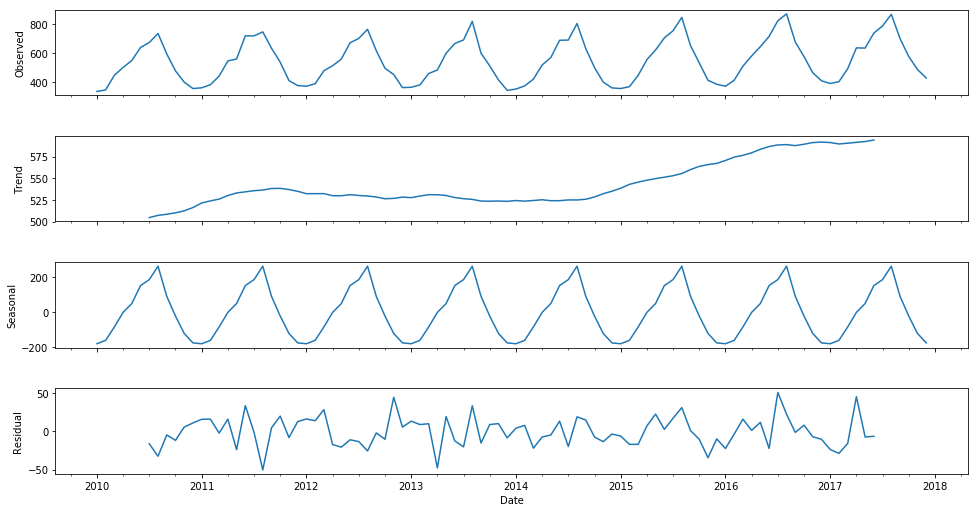

In [52]:
decomposition = seasonal_decompose(dr.Nights, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

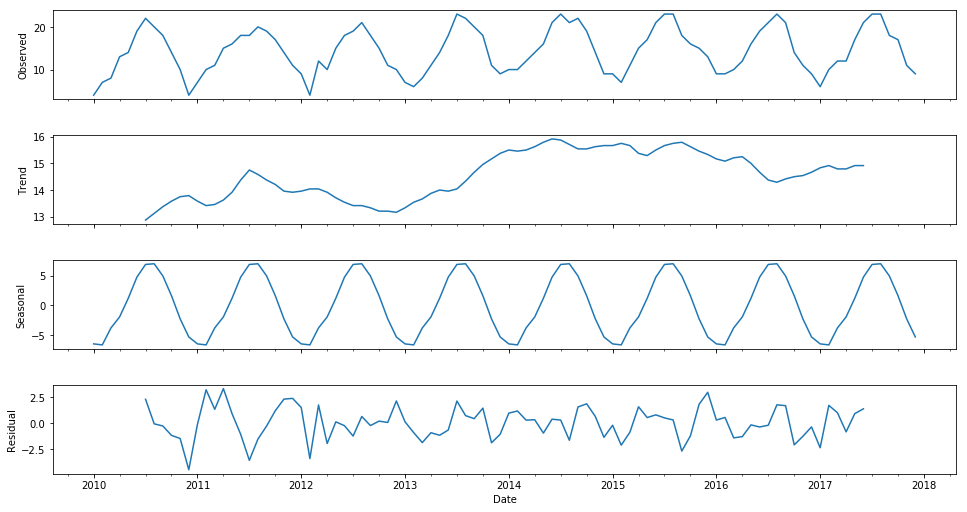

In [53]:
decomposition = seasonal_decompose(dr.AvgTemp, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [54]:
from pyramid.arima import auto_arima
tc_fit = auto_arima(np.array(dr.Nights),  exogeneous=np.array(dr.AvgTemp), start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                    start_P=0, seasonal=True, n_jobs=-1, d=1, D=1, trace=True,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                    n_fits=25)

tc_fit.summary()

Fit ARIMA: order=(5, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 5) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(4, 1, 5)x(0, 1, 1, 12)   Log Likelihood                -377.639
Date:                            Sun, 12 Aug 2018   AIC                            779.278
Time:                                    13:10:09   BIC                            808.304
Sample:                                         0   HQIC                           790.939
                                             - 96                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3440      1.512      0.228      0.820      -2.619       3.307
ar.L1         -0.9123      0.202     -4.510      0.000      -1.309      -0.516
ar.L2         -0.4959      0.276     -1.794      0.073      -1.038       0.046
ar.L3         -0.4004      0.250     -1.600      0.110      -0.891       0.090
ar.L4         -0.5267      0.192     -2.749      0.006      -0.902      -0.151
ma.L1          0.0378     25.926      0.001      0.999     -50.776      50.851
ma.L2         -0.0949     37.067     -0.003      0.998     -72.745      72.555
ma.L3          0.3948     62.435      0.006      0.995    -121.975     122.764
ma.L4          0.3464      1.716      0.202      0.840      -3.016       3.709
ma.L5         -0.7805     46.980     -0.017      0.987     -92.859      91.298
ma.S.L12      -0.5201      0.137     -3.787      0.000      -0.789      -0.251
sigma2       444.2132   2.67e+04      0.017      0.987   -5.19e+04    5.28e+04
===================================================================================
Ljung-Box (Q):                       29.58   Jarque-Bera (JB):                 5.39
Prob(Q):                              0.89   Prob(JB):                         0.07
Heteroskedasticity (H):               1.00   Skew:                             0.62
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
dftrain = dr[(dr.index>='2010-01-01')&(dr.index<'2017-01-01')]
train_nights  = np.array(dftrain.Nights)

dftest = dr[(dr.index>='2017-01-01')&(dr.index<'2018-01-01')]
test_nights = np.array(dftest.Nights)
exogenous_test_meteo=np.array(dftest.AvgTemp)

In [56]:
tc_fit.fit(train_nights)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(4, 1, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [57]:
tc_future_forecast = tc_fit.predict(n_periods=12,exogenous=exogenous_test_meteo)

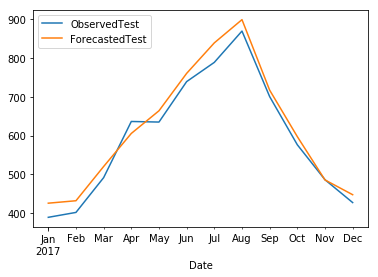

In [58]:
tc_dff = pd.DataFrame(tc_future_forecast, index = dftest.index)
pd.concat([dftest.Nights,tc_dff],axis=1).plot()
L=plt.legend()
L.get_texts()[0].set_text('ObservedTest')
L.get_texts()[1].set_text('ForecastedTest')


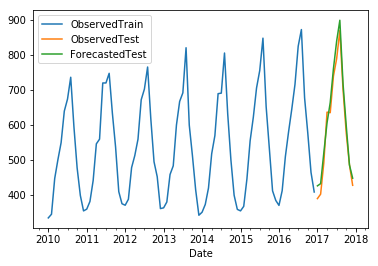

In [59]:
pd.concat([dftrain.Nights,dftest.Nights,tc_dff],axis=1).plot()
L=plt.legend()
L.get_texts()[0].set_text('ObservedTrain')
L.get_texts()[1].set_text('ObservedTest')
L.get_texts()[2].set_text('ForecastedTest')
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from math import sqrt
def MASE(testing_series, prediction_series):
    n = testing_series.shape[0]
    scalingFactor = prediction_series.mean()
    errors = testing_series - prediction_series
    scaledErrors = errors/(np.sum(np.abs(testing_series - scalingFactor)) / n)
    return np.abs(scaledErrors).mean()

In [62]:
mae = mean_absolute_error(test_nights, tc_future_forecast)
print('MAE: %f' % mae)
mse = mean_squared_error(test_nights, tc_future_forecast)
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)
mase = MASE(np.array(test_nights),tc_future_forecast)
print('MASE: %f' % mase)

MAE: 26.295837
MSE: 823.923885
RMSE: 28.704074
MASE: 0.197158
